In [1]:
from z3 import *
import numpy as np
import random
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../"))

# our library
from src.mcmc_sat import smt,mcmc,utils

## Model definition (in Z3)

We start by defining a model as an SMT problem using Z3

In [2]:
# We create five Integer variables
num_vars = 3
x = [Int(f'x{i}') for i in range(num_vars)]

In [3]:
# We define the model using the variables above

s = Solver() # get an instance of a Z3 solver

# model constraints
s.add(x[0]>=0)
s.add(x[1]>=0)
s.add(x[2]>=0)
s.add(x[0]<=3)
s.add(x[1]<=3)
s.add(x[2]<=6)
s.add(x[0] + x[1] == x[2])

## Storing the model

We store the Z3 problem in a smt2 format. This is the input format required by Megasampler.

In [4]:
MEGASAMPLER_INPUT_DIR = 'megasampler_input'
megasampler_input_file = 'z3_synth_problem_2.smt2'
megasampler_input_filepath = f'{MEGASAMPLER_INPUT_DIR}/{megasampler_input_file}'

smt.save_smt2(solver=s, filepath=megasampler_input_filepath)

## Executing Megasampler

Now we execute megasampler to produce 10000 samples (by default). The input to the function is the file where the smt2 version of the Z3 problem is stored.

In [5]:
# We execute megasampler \o/

# NOTE: Megasampler seem to perform very bad in this example? With
#       `algo` options 'MeGA', 'SMT' and 'Z3' failed to generate a set
#       of samples. With `algo` option 'MeGAb' works, but only returns
#       the 16 possible solutions to this problem; it does not sample
#       from them.

MEGASAMPLER_OUTPUT_DIR = 'megasampler_output'
smt.execute_megasampler(input_filepath=megasampler_input_filepath, algo = 'MeGA',
                        output_dir=MEGASAMPLER_OUTPUT_DIR)

FileNotFoundError: [Errno 2] No such file or directory: 'megasampler'

Megasampler stores the samples in a file. The file is stored in the directory passed as parameter in the above function. In what follows, we parse this file to produce a list of samples. Each sample is encoded as a dictionary where the key is the variable name and the value the sample.

In [6]:
# Define output files with samples
file_samples = f'{MEGASAMPLER_OUTPUT_DIR}/{megasampler_input_file}.samples'

In [7]:
# We parse the samples
samples = smt.parse_megasamples(file_samples)

## We run our MCMC algo

Finally, we run our MCMC algorithm. It takes as input the parsed samples. Currently, we always accept the samples. There is no likelihood or prior.

In [9]:
# We run MCMC using the "megasamples"

# NOTE: Here we use the new option uniform_samples. We set it to false
#       to let the algorithm now that we simply have a set of unique
#       solutions to the SMT problem. We do not have a set of samples.

trace = mcmc.sample_mh_trace(10000,4,samples)

The parameter `solver_samples` only contains 1 samples. Thus, every chain will contain 1 instead of 10000. Try running the SAT/SMT sampler longer to obtain more samples.


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [10]:
trace

Inference data with groups:
	> posterior

## Posterior

We conclude by showing the posterior trace plots and summary statistics for each variable.

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:425: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=data.draw.min(), right=data.draw.max())
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:425: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=data.draw.min(), right=data.draw.max())
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:425: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=data.draw.min(), right=data.draw.max())


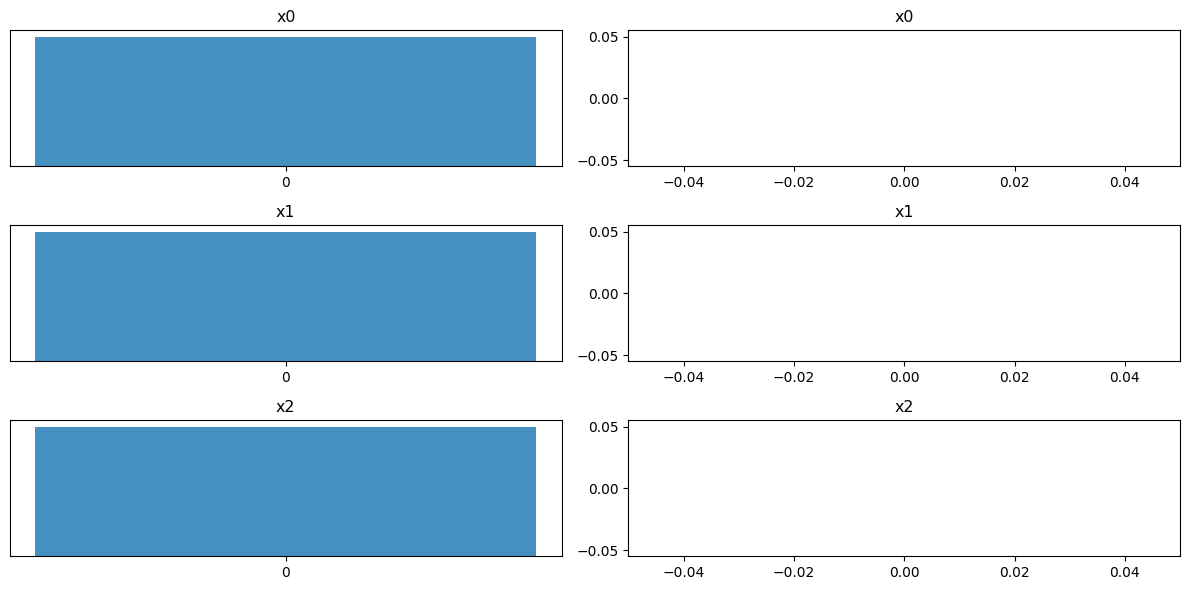

In [11]:
# Plot the posterior
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('megasampler_trace_plot.png', dpi=150);

In [12]:
# Diagnostics
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (4, 1), minimum_shape: (chains=1, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
x1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
x2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [14]:
utils.save_trace(trace, f'triangle_SMT_{num_vars}.nc')